In [194]:
# Initial imports
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor

import numpy as np
import hvplot.pandas
from pathlib import Path

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score




# Extract Data Frmes

In [125]:
import pandas as pd

# Load datasets
veg_df = pd.read_csv('raw_files/Vegetable-Prices-2022.csv')
fru_df = pd.read_csv('raw_files/Fruit-Prices-2022.csv')
more_df = pd.read_csv('raw_files/pp_national_average_prices_csv.csv', encoding='ISO-8859-1')
off_df = pd.read_csv('raw_files/hidden_treasures_groceries_gmm.csv')

## Check Naming Convention and Standardize the values

In [126]:
# Check column names in each dataset
print(veg_df.columns)
print(fru_df.columns)
print(more_df.columns)
print(off_df.columns)

Index(['Vegetable', 'Form', 'RetailPrice', 'RetailPriceUnit', 'Yield',
       'CupEquivalentSize', 'CupEquivalentUnit', 'CupEquivalentPrice'],
      dtype='object')
Index(['Fruit', 'Form', 'RetailPrice', 'RetailPriceUnit', 'Yield',
       'CupEquivalentSize', 'CupEquivalentUnit', 'CupEquivalentPrice'],
      dtype='object')
Index(['year', 'food_code', 'mod_code', 'food_description', 'method',
       'method_description', 'nhanes', 'price_100gm'],
      dtype='object')
Index(['Unnamed: 0', 'energy_100g', 'fat_100g', 'carbohydrates_100g',
       'sugars_100g', 'proteins_100g', 'salt_100g', 'g_sum', 'other_carbs',
       'reconstructed_energy', 'boxcox_carbohydrates_100g',
       'transformed_carbohydrates_100g', 'boxcox_fat_100g',
       'transformed_fat_100g', 'boxcox_proteins_100g',
       'transformed_proteins_100g', 'boxcox_sugars_100g',
       'transformed_sugars_100g', 'boxcox_other_carbs',
       'transformed_other_carbs', 'boxcox_salt_100g', 'transformed_salt_100g',
       'boxco

In [127]:
#Rename columns
veg_df.rename(columns={'Vegetable': 'product'}, inplace=True)
fru_df.rename(columns={'Fruit': 'product'}, inplace=True)
more_df.rename(columns={'food_description': 'product'}, inplace=True)

#keep only relevant columns
veg_df = veg_df[['product', 'RetailPrice']]
fru_df = fru_df[['product', 'RetailPrice']]
more_df = more_df[['product', 'price_100gm']]


In [128]:
#more_df is from 2012 and in different units.  doubling the price for inflation and converting from 100g to price per lb

inflation_factor = 2
grams_per_pound = 453.592
price_per_100g_to_lb = grams_per_pound / 100

# Adjusting for inflation and converting units
# Use .loc to avoid the SettingWithCopyWarning
more_df.loc[:, 'RetailPrice'] = more_df['price_100gm'] * inflation_factor * price_per_100g_to_lb
more_df = more_df.drop(columns=['price_100gm'])

## Inner Merge on Food Product

In [129]:
#Merge the vegetables on 'product' and fruits on 'product' using an inner join
vegnut_df = pd.merge(veg_df, off_df, on='product', how='inner')
fruitnut_df = pd.merge(fru_df, off_df, on='product', how='inner')
morenut_df = pd.merge(more_df, off_df, on='product', how='inner')

In [130]:
#drop duplicates
vegnut_df.drop_duplicates(subset='product', inplace=True)
fruitnut_df.drop_duplicates(subset='product', inplace=True)
morenut_df.drop_duplicates(subset='product', inplace=True)

In [131]:
vegnut_df.to_csv('merged_files/veg.csv', index=False)
fruitnut_df.to_csv('merged_files/fruit.csv', index=False)
morenut_df.to_csv('merged_files/more.csv', index=False)

# Stack Data Frames

In [132]:
working_df = pd.concat([vegnut_df, fruitnut_df, morenut_df], ignore_index=True)


In [133]:


# Dropping unnecessary columns such as 'Unnamed: 0'
df_cleaned = working_df.drop(columns=['Unnamed: 0'])

# Step 2: Check for missing values
missing_values = df_cleaned.isnull().sum()

# Step 3: Drop rows with missing target values (if any)
df_cleaned = df_cleaned.dropna(subset=['RetailPrice'])


# Clean up and Data Frame

In [134]:


df_cleaned.to_csv('working.csv', index=False)

In [135]:
# Load the dataset
df = pd.read_csv('working.csv')
df.head()


,product,RetailPrice,energy_100g,fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,g_sum,other_carbs,...,boxcox_reconstructed_energy,transformed_reconstructed_energy,boxcox_g_sum,transformed_g_sum,cluster,category,certainty,alternative_cluster,alternative_category,anomaly
0,Artichoke,2.4703,314.0,6.67,3.33,1.67,1.67,0.76200,12.0,1.66,...,-0.263470,-1.033042,-0.290163,-1.195525,4,creams & dips,1.0000,6,strange cluster 6,0
1,Asparagus,2.9531,222.0,3.53,3.53,1.18,2.35,0.14986,10.0,2.35,...,-0.416842,-1.207215,-0.381893,-1.241809,4,creams & dips,0.6441,18,tomato sauce,0
2,Beets,1.1431,167.0,0.00,10.00,2.00,2.00,0.12700,12.0,8.00,...,-0.458748,-1.254806,-0.290163,-1.195525,18,tomato sauce,0.9965,1,beans & peas,0
3,Broccoli,2.3458,121.0,0.00,4.71,2.35,3.53,0.07366,8.0,2.36,...,-0.562940,-1.373130,-0.470604,-1.286569,18,tomato sauce,1.0000,8,yoghurt and milk,0
4,Carrots,1.1979,159.0,0.00,8.97,6.41,1.28,0.19558,10.0,2.56,...,-0.506612,-1.309162,-0.381893,-1.241809,18,tomato sauce,0.9999,8,yoghurt and milk,0


In [136]:
df.columns

Index(['product', 'RetailPrice', 'energy_100g', 'fat_100g',
       'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g',
       'g_sum', 'other_carbs', 'reconstructed_energy',
       'boxcox_carbohydrates_100g', 'transformed_carbohydrates_100g',
       'boxcox_fat_100g', 'transformed_fat_100g', 'boxcox_proteins_100g',
       'transformed_proteins_100g', 'boxcox_sugars_100g',
       'transformed_sugars_100g', 'boxcox_other_carbs',
       'transformed_other_carbs', 'boxcox_salt_100g', 'transformed_salt_100g',
       'boxcox_energy_100g', 'transformed_energy_100g',
       'boxcox_reconstructed_energy', 'transformed_reconstructed_energy',
       'boxcox_g_sum', 'transformed_g_sum', 'cluster', 'category', 'certainty',
       'alternative_cluster', 'alternative_category', 'anomaly'],
      dtype='object')

<Axes: >

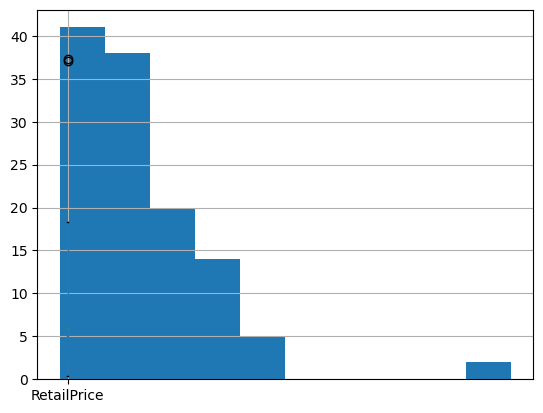

In [137]:
df['RetailPrice'].hist()
df.boxplot(column=['RetailPrice'])

<Axes: xlabel='RetailPrice', ylabel='product'>

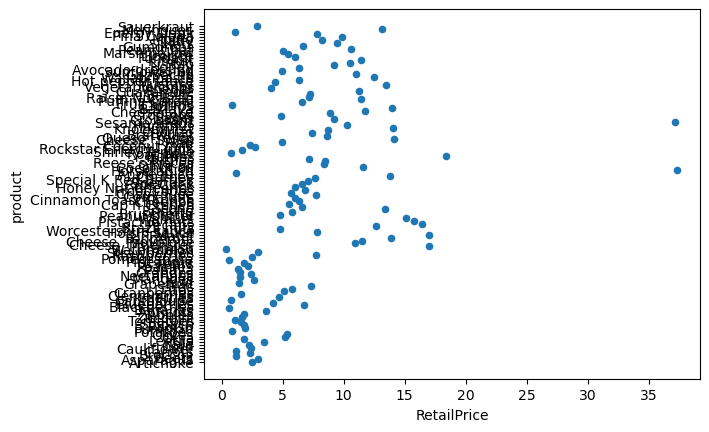

In [138]:
df.plot.scatter(x='RetailPrice', y='product')

In [139]:
# Remove rows where RetailPrice is greater than 30
df_no_outliers = df[df['RetailPrice'] <= 30]

<Axes: >

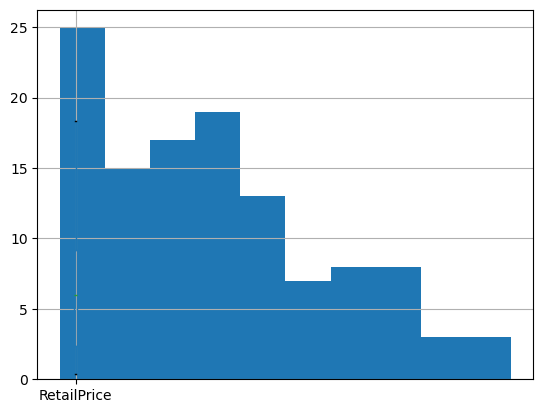

In [140]:
df_no_outliers['RetailPrice'].hist()
df_no_outliers.boxplot(column=['RetailPrice'])

<Axes: xlabel='RetailPrice', ylabel='product'>

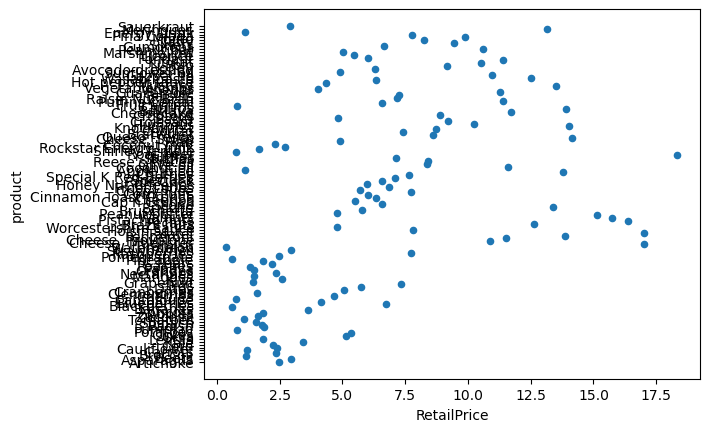

In [141]:
df_no_outliers.plot.scatter(x='RetailPrice', y='product')

The shape of the data is less apparent after taking out the outliers becuase the scatter is more distributed.

In [142]:
#essential columns
features = ["transformed_carbohydrates_100g",
            "transformed_fat_100g",
            "transformed_proteins_100g",
            "transformed_sugars_100g",
            "transformed_salt_100g",
            "transformed_other_carbs",
            "transformed_energy_100g",
            "transformed_reconstructed_energy",
            "transformed_g_sum"]

target = ['RetailPrice']

#make new data frame with only selected features and price


df_essentials = df_no_outliers[features + target]

**g_sum** represents the rounded sum of the fat-, carbohydrates-, proteins- and salt-values in our data. By doing that we can easily see if there are some products with false entries

**reconstructed_engery** calculates the energy value of a product based on energy values of the features fat, carbohydrates and proteins. We can compare this feature to the amount of energy that is given in our dataset to see if there possibly are some wrong entries.

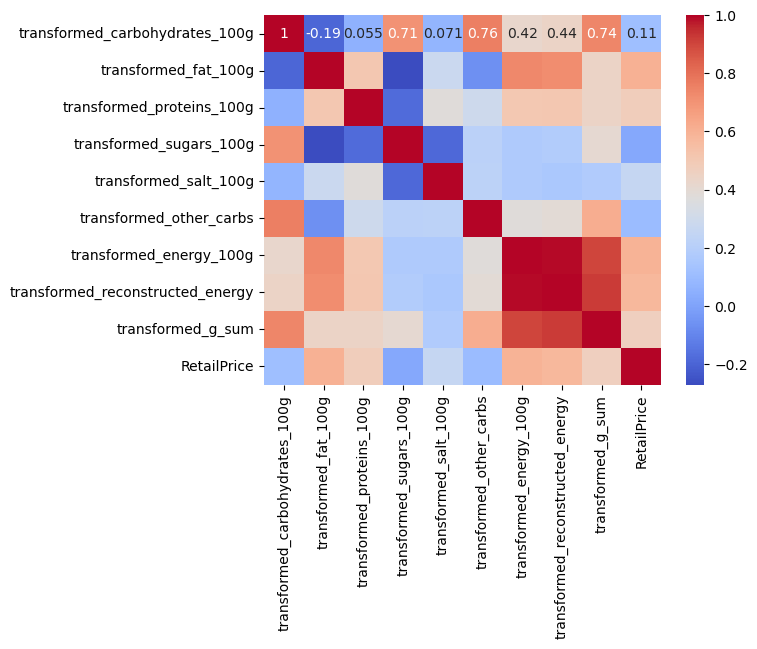

In [173]:
sns.heatmap(df_essentials.corr(), annot=True, cmap='coolwarm')
plt.show()

Retail Price has the least correlation between all the features.  Being able to predict the price based on features may be difficult.  The Transformed reconstructed energy and transformed g sum are highly positively correlated and may overfit the model.

**Multicollinearity** Reduces Model Accuracy: The high VIF values, particularly for transformed_reconstructed_energy, transformed_g_sum, and transformed_energy_100g, suggest that these features carry overlapping information. The model can’t determine the individual contribution of these features effectively, which reduces the overall explanatory power (reflected in the moderate R-squared values)

	**Ridge Regularization** Helps, but Doesn’t Eliminate the Problem: Ridge regression helps reduce the impact of multicollinearity by shrinking coefficients, but with VIF values as high as these, it’s still difficult for the model to generalize well. This explains why you’re getting a moderate R-squared despite using regularization.

# Model Data

In [174]:
# Prepare the data for training
X = df_essentials[features]
y = df_essentials[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Linear Regression

In [197]:
# Create and train the linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Make predictions on the test set
line_y_pred = linear_model.predict(X_test)

# Calculate performance metrics
line_mse = mean_squared_error(y_test, line_y_pred)
line_r2 = r2_score(y_test, line_y_pred)

# Display the coefficients, MSE, and R-squared value
line_coefficients = linear_model.coef_
line_intercept = linear_model.intercept_

print("Mean Squared Error:", line_mse)
print("R-squared:", line_r2)

line_coefficients, line_intercept

Mean Squared Error: 12.495409510694495
R-squared: 0.43026604968281645


(array([[ 4.39742289,  1.306242  ,  1.38420076, -0.15669228,  0.42726292,
         -0.77221426,  3.26476944,  3.50819228, -8.82268856]]),
 array([7.23804863]))

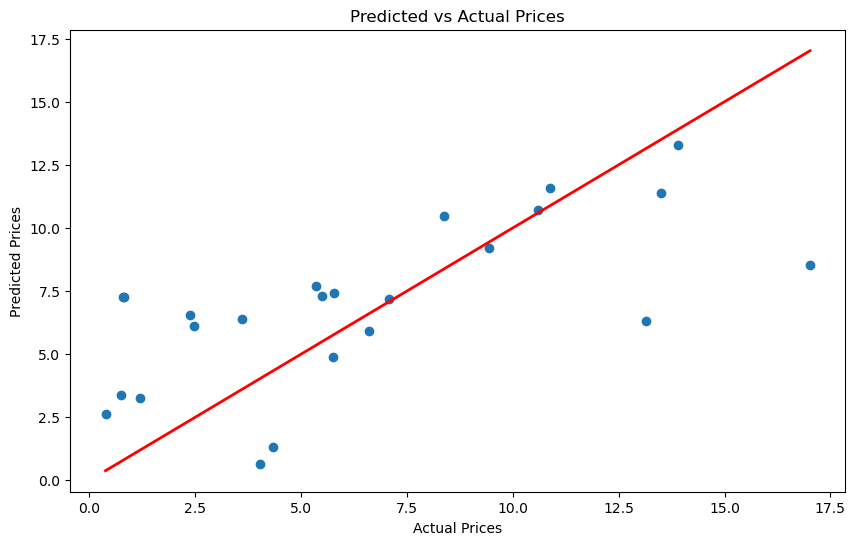

In [198]:
# Create a scatter plot for predicted vs actual prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, line_y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Predicted vs Actual Prices')
plt.show()

 Linear regression assumes linear relationships, no multicollinearity, homoscedasticity, etc. 

# Inspection: How Features add up to Retail Price

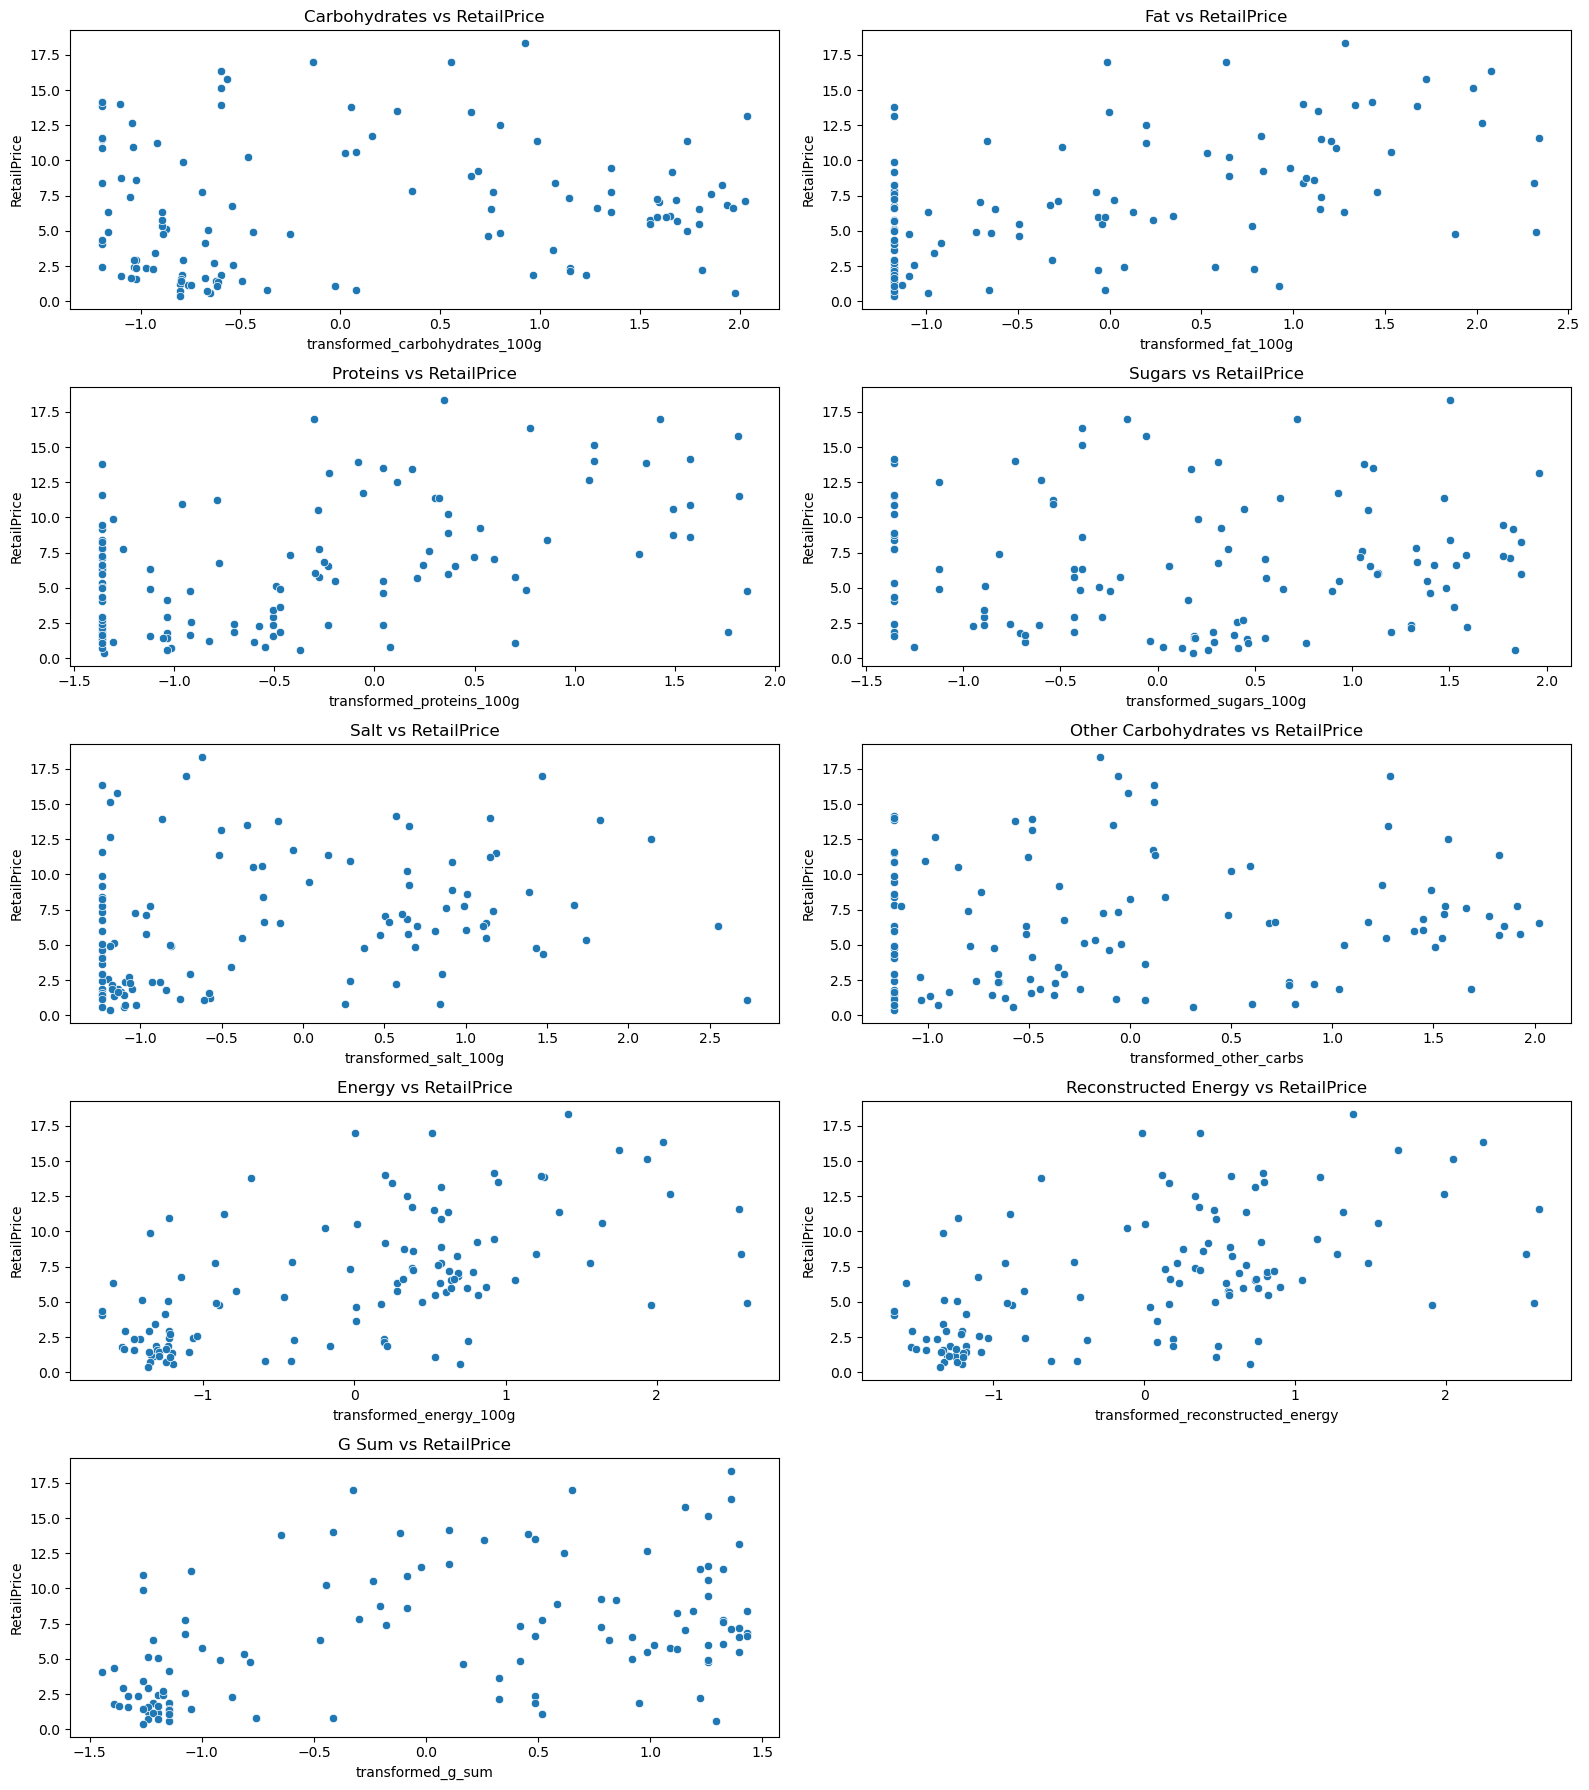

In [199]:
# Set up the figure and axis for subplots (4 rows, 2 columns, to accommodate 9 features)
fig, axes = plt.subplots(5, 2, figsize=(16, 18))

# Scatter plots of each feature vs RetailPrice
sns.scatterplot(x='transformed_carbohydrates_100g', y='RetailPrice', data=df_essentials, ax=axes[0, 0])
axes[0, 0].set_title('Carbohydrates vs RetailPrice')

sns.scatterplot(x='transformed_fat_100g', y='RetailPrice', data=df_essentials, ax=axes[0, 1])
axes[0, 1].set_title('Fat vs RetailPrice')

sns.scatterplot(x='transformed_proteins_100g', y='RetailPrice', data=df_essentials, ax=axes[1, 0])
axes[1, 0].set_title('Proteins vs RetailPrice')

sns.scatterplot(x='transformed_sugars_100g', y='RetailPrice', data=df_essentials, ax=axes[1, 1])
axes[1, 1].set_title('Sugars vs RetailPrice')

sns.scatterplot(x='transformed_salt_100g', y='RetailPrice', data=df_essentials, ax=axes[2, 0])
axes[2, 0].set_title('Salt vs RetailPrice')

sns.scatterplot(x='transformed_other_carbs', y='RetailPrice', data=df_essentials, ax=axes[2, 1])
axes[2, 1].set_title('Other Carbohydrates vs RetailPrice')

sns.scatterplot(x='transformed_energy_100g', y='RetailPrice', data=df_essentials, ax=axes[3, 0])
axes[3, 0].set_title('Energy vs RetailPrice')

sns.scatterplot(x='transformed_reconstructed_energy', y='RetailPrice', data=df_essentials, ax=axes[3, 1])
axes[3, 1].set_title('Reconstructed Energy vs RetailPrice')

sns.scatterplot(x='transformed_g_sum', y='RetailPrice', data=df_essentials, ax=axes[4, 0])
axes[4, 0].set_title('G Sum vs RetailPrice')

# Hide the last unused subplot
axes[4, 1].axis('off')

# Adjust the layout
plt.tight_layout()
plt.show()

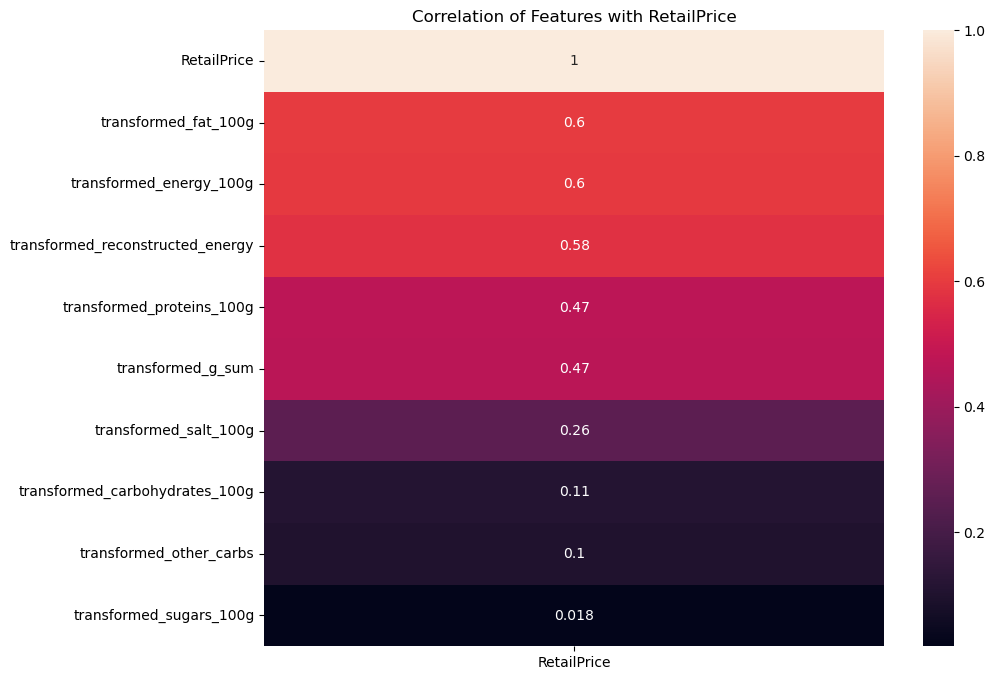

In [200]:
# Correlation matrix
corr_matrix = df_essentials.corr()

# Visualize correlations with the target (RetailPrice)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix[['RetailPrice']].sort_values(by='RetailPrice', ascending=False), annot=True)
plt.title('Correlation of Features with RetailPrice')
plt.show()

Why Linear Regression Struggles with Clusters:

	1.	Assumption of Linearity: Linear regression assumes a single, continuous linear relationship between the independent variables and the target variable across the entire dataset. If your data has clusters with different relationships or patterns, a single linear model might not fit well for all clusters.
	2.	Different Cluster Behaviors: If each cluster behaves differently (e.g., one cluster shows a positive correlation and another shows a negative correlation), linear regression will struggle to capture these different trends in one model, potentially leading to poor performance.
	3.	Overlapping Clusters: If the clusters overlap in feature space, linear regression won’t differentiate between them, treating the entire dataset as one continuous set of points.


# Random Forest

In [209]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

/var/folders/y9/yjkwjxy552l0r3g66ghndhyh0000gn/T/ipykernel_50183/1094029602.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [210]:
forest_y_pred = rf.predict(X_test)

forest_r2 = r2_score(y_test, forest_y_pred)
forest_mse = mean_squared_error(y_test, forest_y_pred)

In [211]:
print("Random Forest R-squared:", forest_r2)
print("Linear Regression R-squared:", line_r2)

print("Random Forest Mean Squared Error:", forest_mse)
print("Linear Regression Mean Squared Error:", line_mse)

Random Forest R-squared: 0.36392973205179613
Linear Regression R-squared: 0.43026604968281645
Random Forest Mean Squared Error: 13.950298154366925
Linear Regression Mean Squared Error: 12.495409510694495


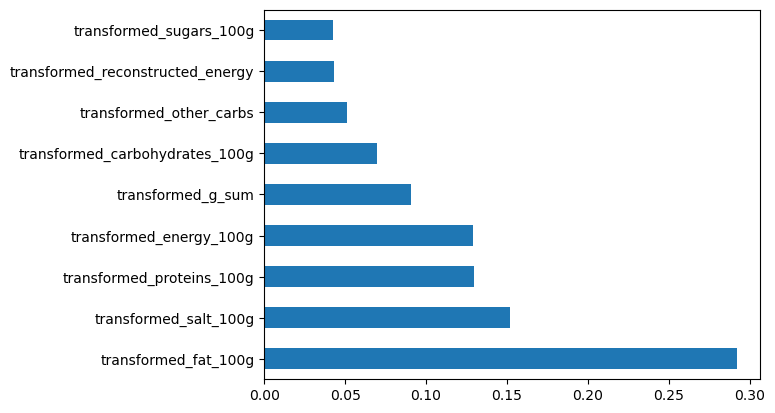

In [203]:
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.show()

In [212]:
from sklearn.linear_model import Ridge

# Apply Ridge regression
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

Ridge()

In [218]:
# Predict on the training set
ridge_y_train_pred = ridge_model.predict(X_train)

# Predict on the test set
ridge_y_test_pred = ridge_model.predict(X_test)

In [219]:
# Calculate training MSE and R²
train_mse_ridge = mean_squared_error(y_train, ridge_y_train_pred)
train_r2_ridge = r2_score(y_train, ridge_y_train_pred)

print("Training Mean Squared Error:", train_mse_ridge)
print("Training R-squared:", train_r2_ridge)

Training Mean Squared Error: 10.588567035517631
Training R-squared: 0.46145753715256954


In [220]:
# Calculate test MSE and R²
test_mse_ridge = mean_squared_error(y_test, ridge_y_test_pred)
test_r2_ridge = r2_score(y_test, ridge_y_test_pred)

print("Test Mean Squared Error:", test_mse_ridge)
print("Test R-squared:", test_r2_ridge)

Test Mean Squared Error: 11.171109490156022
Test R-squared: 0.4906481189107802


In [227]:
# Printing out the metrics with additional percentage improvement


# Calculate R-squared improvement between Random Forest and Linear Regression
r2_improvement_rf_vs_lr = (line_r2 - forest_r2) / abs(forest_r2) * 100

# Calculate MSE improvement between Random Forest and Linear Regression
mse_improvement_rf_vs_lr = (forest_mse - line_mse) / forest_mse * 100


# Calculate R-squared improvement between RF and Ridge
r2_improvement_rf_vs_ridge = (test_r2_ridge - forest_r2) / abs(forest_r2) * 100


# Calculate MSE improvement between RF and Ridge
mse_improvement_rf_vs_ridge = (test_r2_ridge - forest_mse) / abs(forest_mse) * 100


print("Random Forest R-squared:", forest_r2)
print("Linear Regression R-squared:", line_r2)
print("R-squared improvement from Random Forest to Linear Regression: {:.2f}%".format(r2_improvement_rf_vs_lr))

print("\nRandom Forest Mean Squared Error:", forest_mse)
print("Linear Regression Mean Squared Error:", line_mse)
print("MSE improvement from Random Forest to Linear Regression: {:.2f}%".format(mse_improvement_rf_vs_lr))

print("\n\n\nRandom Forest R-squared:", forest_r2)
print("Test R-squared (Ridge):", test_r2_ridge)
print("R-squared improvement from Random Forest to Ridge: {:.2f}%".format(r2_improvement_rf_vs_ridge))

print("\nRandom Forest Mean Squared Error:", forest_mse)
print("Test Mean Squared Error (Ridge):", test_mse_ridge)
print("MSE improvement from Linear Regression to Ridge: {:.2f}%".format(mse_improvement_rf_vs_ridge))

Random Forest R-squared: 0.36392973205179613
Linear Regression R-squared: 0.43026604968281645
R-squared improvement from Random Forest to Linear Regression: 18.23%

Random Forest Mean Squared Error: 13.950298154366925
Linear Regression Mean Squared Error: 12.495409510694495
MSE improvement from Random Forest to Linear Regression: 10.43%



Random Forest R-squared: 0.36392973205179613
Test R-squared (Ridge): 0.4906481189107802
R-squared improvement from Random Forest to Ridge: 34.82%

Random Forest Mean Squared Error: 13.950298154366925
Test Mean Squared Error (Ridge): 11.171109490156022
MSE improvement from Linear Regression to Ridge: -96.48%


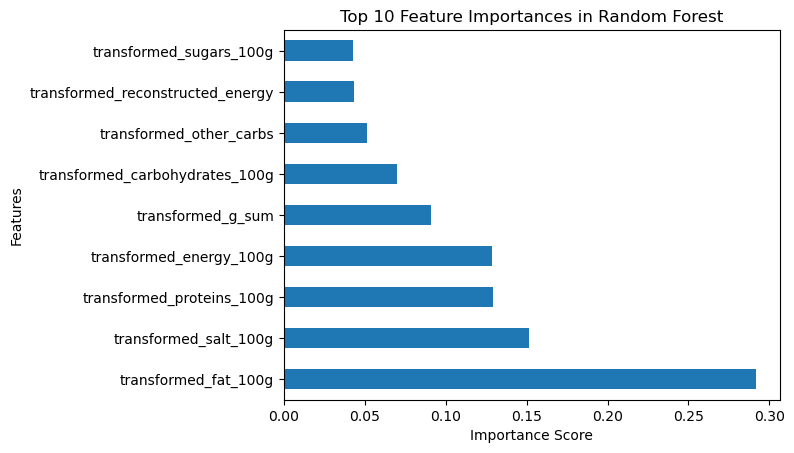

In [190]:
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Feature Importances in Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

In [191]:

# Select only the numeric features for VIF calculation
#numeric_features = df_cleaned.drop(columns=['RetailPrice', 'product', 'category', 'alternative_category', 'cluster', 'alternative_cluster', 'anomaly'])

# Add a constant to the features matrix for the VIF calculation
variance_IF = df_essentials.assign(constant=1)

# Calculate VIF for each feature
vif = pd.DataFrame()
vif['Feature'] = variance_IF.columns
vif['VIF'] = [variance_inflation_factor(variance_IF.values, i) for i in range(variance_IF.shape[1])]

# Show the VIF values
print(vif)

                             Feature         VIF
0     transformed_carbohydrates_100g   39.786989
1               transformed_fat_100g   10.062862
2          transformed_proteins_100g    2.560955
3            transformed_sugars_100g    4.677926
4              transformed_salt_100g    1.858409
5            transformed_other_carbs    5.595568
6            transformed_energy_100g   95.999928
7   transformed_reconstructed_energy  230.609919
8                  transformed_g_sum  136.725746
9                        RetailPrice    1.939766
10                          constant    6.251324


In [195]:

cv_scores = cross_val_score(linear_model, X, y, cv=5, scoring='r2')
print(f"Mean cross-validated R-squared: {cv_scores.mean()}")

Mean cross-validated R-squared: -0.7830935838602053
